# Literature Review

In [9]:
from pathlib import Path

data_file = lambda filename: Path().resolve().parent.joinpath(*['data', filename])
cache_file = lambda filename: Path().resolve().parent.joinpath(*['cache', filename])
figure_file = lambda filename: Path().resolve().parent.joinpath(*['figures', filename])

def createDirectories():
    DATA = Path().resolve().parent.joinpath('data')
    CACHE = Path().resolve().parent.joinpath('cache')
    FIGURES = Path().resolve().parent.joinpath('figures')
    for directory in [DATA, CACHE, FIGURES]:
        try:
            directory.mkdir()
            print('directory created')
        except FileExistsError:
            print('directory already exists')

createDirectories()

directory created
directory created
directory created


In [6]:
import json

"""require a bigquery project and credentials, save in json in root main directory"""
credsfile = Path().resolve().parent.joinpath('credentials.json')
creds = json.load(open(credsfile))
PROJECT = creds["PROJECT"]
CREDENTIALS = Path().resolve().parent.joinpath(creds["CREDENTIALS"])

In [4]:
from google.cloud import bigquery
import pandas as pd
from tqdm import tqdm
from google.cloud import bigquery
from concurrent.futures import TimeoutError
import os
import numpy as np

def client():
    return bigquery.Client.from_service_account_json(CREDENTIALS, project=PROJECT)

def jobConfig():
    config = bigquery.QueryJobConfig()
    config.query_parameters = (bigquery.ScalarQueryParameter('size', 'INT64', 10),)
    config.use_legacy_sql = False
    config.maximum_bytes_billed = int(5e9)
    
    return config

def run_job(query):
    print('Submitting query')
    j = client().query(query=query, job_config=jobConfig())
    with tqdm() as pbar:
        while True:
            try:
                j.result(timeout=1)
            except TimeoutError:                
                pbar.update(1)
            else:
                break
    return j

def unpack_results(j):
    print('Unpacking results')
    
    total = j.query_results().total_rows
    
    iterator = j.result()
    rows = []
    for row in tqdm(iterator, total=total):
        rows.append(row.values())
    
    columns = [c.name for c in iterator.schema]
    df = pd.DataFrame(rows, None, columns)
    
    return df


def fetchQuery(query):
    j = run_job(query)
    df = unpack_results(j)
    
    return df

In [7]:
def getTDIn():
    query = """SELECT author, COUNT(*) as count
                    FROM `fh-bigquery.reddit_comments.2017_06`
                    WHERE (subreddit IN ('The_Donald')) and (author NOT IN ('[deleted]'))
                    GROUP BY author"""

    df = fetchQuery(query)
    df.to_csv(data_file('TDauthorInCounts.csv'))
    
    return df


def fetchInSubredditData():
    getTDIn()
    getCMVIn()
    getSampleSubreddits()

Submitting query


0it [00:00, ?it/s]
  0%|          | 0/52206 [00:00<?, ?it/s]

Unpacking results


100%|██████████| 52206/52206 [00:02<00:00, 23059.41it/s]


In [17]:
def getCMVIn():
    query = """SELECT author, COUNT(*) as count
                    FROM `fh-bigquery.reddit_comments.2017_06`
                    WHERE (subreddit IN ('changemyview')) and (author NOT IN ('[deleted]'))
                    GROUP BY author"""

    df = fetchQuery(query)
    df.to_csv(data_file('CMVauthorInCounts.csv'))
    
    return df

In [30]:
def getSampleSubreddits(LIMIT=10):
    query = """SELECT subreddit
                FROM `fh-bigquery.reddit_comments.2017_06`
                ORDER BY RAND()
                LIMIT {}""".format(LIMIT)

    df = fetchQuery(query)
    df.to_csv(data_file('sampleSubreddits.csv'))

In [31]:
getSampleSubreddits()
sampleSubreddits = pd.read_csv(data_file('sampleSubreddits.csv'), index_col=0)

Submitting query


1it [00:01,  1.28s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Unpacking results


100%|██████████| 10/10 [00:00<00:00, 21.72it/s]


In [41]:
subs = list(sampleSubreddits['subreddit'])
names = "'" + "','".join(names)+ "'"

In [92]:
def getSubredditInCounts(sampleSubreddits):
    subs = ['The_Donald', 'changemyview'] + list(sampleSubreddits['subreddit'])
    names = "'" + "','".join(subs)+ "'"
    query = """SELECT subreddit, author, COUNT(*) as count
                    FROM `fh-bigquery.reddit_comments.2017_06`
                    WHERE (subreddit IN ({})) and (author NOT IN ('[deleted]'))
                    GROUP BY subreddit, author""".format(names)

    df = fetchQuery(query)
    df.to_csv(data_file('SubredditInCounts.csv'))
    
getSubredditInCounts(sampleSubreddits)

Submitting query


0it [00:00, ?it/s]
  0%|          | 0/366284 [00:00<?, ?it/s]

Unpacking results


100%|██████████| 366284/366284 [00:17<00:00, 21277.47it/s]


(366284, 4)

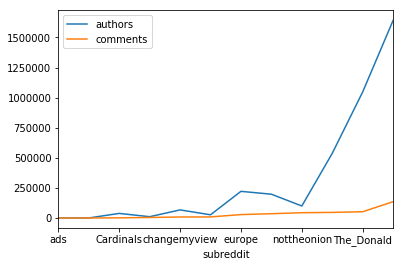

In [99]:
%matplotlib inline
InCounts.sort_values('comments').plot();

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt


def getOutComments():
    InSubredditDf = pd.read_csv(data_file('SubredditInCounts.csv'))
    sample_authors = list(InSubredditDf['author'].unique())
    names = "'" + "','".join(sample_authors)+ "'"
    query = """SELECT subreddit, author, COUNT(*) as count
                    FROM `fh-bigquery.reddit_comments.2017_06`
                    WHERE (author IN ({})) and (author NOT IN ('[deleted]'))
                    GROUP BY subreddit, author""".format(names)

    df = fetchQuery(query)
    df.to_csv(data_file('SubredditOutCounts.csv'))
    
def subAvgPlot(counts):
    fix, ax = plt.subplots()
    counts.plot(ax=ax, color='black', label='Random Subs')
    plt.axvline(counts.loc['changemyview'], color='blue', label='CMV')
    plt.axvline(counts.loc['The_Donald'], color='red', label='TD')
    plt.legend(loc=1);

In [192]:
InSubredditDf = pd.read_csv(data_file('SubredditInCounts.csv'))
InCounts = getSubredditCountDf(InSubredditDf)

In [207]:
getSubredditOutCounts()

Submitting query


3it [00:04,  1.49s/it]
  0%|          | 0/186968 [00:00<?, ?it/s]

Unpacking results


100%|██████████| 186968/186968 [00:10<00:00, 18148.29it/s]


In [174]:
OutSubredditDf = pd.read_csv(data_file('SubredditOutCounts.csv'), index_col=0)
authorOutSubredditCount = OutSubredditDf.groupby('author')['subreddit'].count()
OutSubredditDf['authorOutSubreddits'] = OutSubredditDf['author'].apply(lambda x: authorOutSubredditCount.loc[x])
avgOutSub = OutSubredditDf.groupby('subreddit')['authorOutSubreddits'].mean().sort_values()
outSubPlot(avgOutSub)

subreddit
SkypeShows    4389.0
SlavesUK      4389.0
Slutoon       4389.0
SickJunk      4389.0
zuthar13      4389.0
Name: authorOutSubreddits, dtype: float64

In [220]:
def countDf(df, groupby='subreddit'):
    variable = 'author'
    if groupby == 'author':
        variable = 'subreddit'
    counts = pd.concat([df.groupby(groupby)[variable].count(),
               df.groupby(groupby)['count'].sum(),
                df.groupby(groupby)['count'].mean()], axis=1)
    counts.columns = ['n'+variable,'comments','avg#comments']
    
    return counts

In [221]:
OutSubredditDf = pd.read_csv(data_file('SubredditOutCounts.csv'), index_col=0)
authorCounts = countDf(OutSubredditDf, 'author')
InSubredditDf = pd.read_csv(data_file('SubredditInCounts.csv'), index_col=0)
merged = InSubredditDf.merge(authorCounts, left_on='author', right_index=True)
merged['inRate'] = merged['count']/merged['comments']
merged.head()

,subreddit,author,count,nsubreddit,comments,avg#comments,inRate
11,ads,johnrome784,1,2,2,1.000000,0.500000
12,ads,alsotri,1,6,53,8.833333,0.018868
13,ads,MonsterCrufix,1,5,12,2.400000,0.083333
14,ads,bestbingodeal15,1,1,1,1.000000,1.000000
15,ads,softwaremakerz,1,21,23,1.095238,0.043478


In [294]:
avgInRates = merged.groupby('subreddit')['inRate'].median().sort_values()

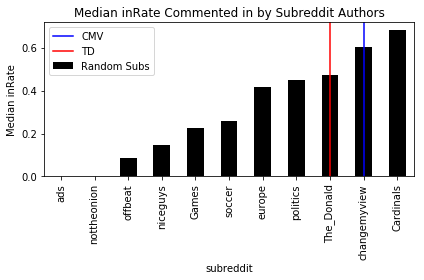

In [308]:
from itertools import cycle, islice

def subPlot(df, variable):
    counts = df.groupby('subreddit')[variable].median().sort_values()
    fix, ax = plt.subplots()
    
    cols = ['black']*len(counts.index)
    cols[counts.index.get_loc('changemyview')] = 'blue'
    cols[counts.index.get_loc('The_Donald')] = 'red'
    counts.plot(ax=ax, label='Random Subs', kind='bar', color=cols) # why cols not working?
    plt.axvline(counts.index.get_loc('changemyview'), color='blue', label='CMV')
    plt.axvline(counts.index.get_loc('The_Donald'), color='red', label='TD')
    plt.ylabel(f'Median {variable}')
    plt.legend(loc=2)
    plt.title(f'Median {variable} Commented in by Subreddit Authors')
    plt.tight_layout()

df = merged[(merged['count']>100)&(merged['nsubreddit']>20)]
subPlot(df, 'inRate')

In [310]:
df.groupby('subreddit')['inRate'].median().describe()

count    11.000000
mean      0.303903
std       0.236416
min       0.000288
25%       0.115697
50%       0.259271
75%       0.461821
max       0.683706
Name: inRate, dtype: float64

In [312]:
df.groupby('subreddit')['inRate'].median().shape

(11,)

In [313]:
InSubredditDf = pd.read_csv(data_file('SubredditInCounts.csv'), index_col=0)

In [315]:
InSubredditDf.author.unique().shape

(310938,)

In [347]:
InSubredditDf = pd.read_csv(data_file('SubredditInCounts.csv'))

authors = list(InSubredditDf['author'].unique())
blocks = [15000*n for n in range (0,np.round(len(authors)/15000))]
ranges = list(zip(blocks, blocks[1:]))

chunks = []
for r in ranges:
    start, end = r
    chunks.append(authors[start:end])
chunks.append(authors[blocks[-1]:])

dfs = []
for c in tqdm(chunks):
    names = "'" + "','".join(c)+ "'"
    query = """SELECT subreddit, author, COUNT(*) as count
                    FROM `fh-bigquery.reddit_comments.2017_06`
                    WHERE (author IN ({})) and (author NOT IN ('[deleted]'))
                    GROUP BY subreddit, author""".format(names)

    df = fetchQuery(query)
    dfs.append(df)

  0%|          | 0/20 [00:00<?, ?it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.36s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.36s/it]

  0%|          | 0/174502 [00:00<?, ?it/s]

Unpacking results



  5%|▌         | 1/20 [00:18<05:52, 18.55s/it]5252.98it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.34s/it]
2it [00:02,  1.33s/it]
3it [00:03,  1.32s/it]
4it [00:05,  1.34s/it]

  0%|          | 0/221069 [00:00<?, ?it/s]

Unpacking results



 10%|█         | 2/20 [00:37<05:33, 18.51s/it]9961.42it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.39s/it]
2it [00:02,  1.37s/it]
3it [00:04,  1.35s/it]
4it [00:05,  1.36s/it]
5it [00:06,  1.38s/it]

  0%|          | 0/104914 [00:00<?, ?it/s]

Unpacking results



 15%|█▌        | 3/20 [00:52<04:59, 17.61s/it]5584.52it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.32s/it]
2it [00:02,  1.31s/it]
3it [00:03,  1.33s/it]
4it [00:05,  1.33s/it]

  0%|          | 0/248857 [00:00<?, ?it/s]

Unpacking results



 20%|██        | 4/20 [01:13<04:52, 18.29s/it]9427.50it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.32s/it]
3it [00:03,  1.31s/it]

  0%|          | 0/142026 [00:00<?, ?it/s]

Unpacking results



 25%|██▌       | 5/20 [01:29<04:27, 17.87s/it]6072.03it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.44s/it]
2it [00:02,  1.40s/it]
3it [00:04,  1.40s/it]

  0%|          | 0/149984 [00:00<?, ?it/s]

Unpacking results



 30%|███       | 6/20 [01:45<04:05, 17.50s/it]6840.12it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.39s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.35s/it]

  0%|          | 0/158117 [00:00<?, ?it/s]

Unpacking results



 35%|███▌      | 7/20 [02:00<03:43, 17.22s/it]8655.50it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.33s/it]
2it [00:02,  1.34s/it]
3it [00:04,  1.34s/it]

  0%|          | 0/124027 [00:00<?, ?it/s]

Unpacking results



 40%|████      | 8/20 [02:14<03:21, 16.79s/it]8865.36it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.31s/it]
3it [00:04,  1.34s/it]

  0%|          | 0/255435 [00:00<?, ?it/s]

Unpacking results



 45%|████▌     | 9/20 [02:35<03:09, 17.25s/it]8224.91it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.38s/it]
2it [00:02,  1.36s/it]
3it [00:03,  1.34s/it]
4it [00:05,  1.35s/it]

  0%|          | 0/236568 [00:00<?, ?it/s]

Unpacking results



 50%|█████     | 10/20 [02:55<02:55, 17.55s/it]898.45it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.35s/it]
2it [00:02,  1.34s/it]
3it [00:03,  1.33s/it]

  0%|          | 0/181623 [00:00<?, ?it/s]

Unpacking results



 55%|█████▌    | 11/20 [03:11<02:37, 17.45s/it]868.80it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.39s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.37s/it]

  0%|          | 0/167594 [00:00<?, ?it/s]

Unpacking results



 60%|██████    | 12/20 [03:27<02:18, 17.31s/it]726.85it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.38s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.35s/it]

  0%|          | 0/216465 [00:00<?, ?it/s]

Unpacking results



 65%|██████▌   | 13/20 [03:45<02:01, 17.33s/it]799.51it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.30s/it]
3it [00:03,  1.30s/it]

  0%|          | 0/186137 [00:00<?, ?it/s]

Unpacking results



 70%|███████   | 14/20 [04:02<01:43, 17.31s/it]788.34it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.34s/it]
3it [00:04,  1.34s/it]

  0%|          | 0/205435 [00:00<?, ?it/s]

Unpacking results



 75%|███████▌  | 15/20 [04:21<01:27, 17.42s/it]125.89it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.39s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.36s/it]

  0%|          | 0/195315 [00:00<?, ?it/s]

Unpacking results



 80%|████████  | 16/20 [04:38<01:09, 17.42s/it]577.63it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.37s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.35s/it]

  0%|          | 0/194016 [00:00<?, ?it/s]

Unpacking results



 85%|████████▌ | 17/20 [04:56<00:52, 17.44s/it]059.61it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.35s/it]
2it [00:02,  1.33s/it]
3it [00:04,  1.35s/it]
4it [00:05,  1.33s/it]

  0%|          | 0/198157 [00:00<?, ?it/s]

Unpacking results



 90%|█████████ | 18/20 [05:17<00:35, 17.66s/it]968.76it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.47s/it]
2it [00:02,  1.42s/it]
3it [00:04,  1.42s/it]

  0%|          | 0/203381 [00:00<?, ?it/s]

Unpacking results



 95%|█████████▌| 19/20 [05:37<00:17, 17.76s/it]480.16it/s]

Submitting query


BadRequest: 400 POST https://www.googleapis.com/bigquery/v2/projects/reddit-network-184710/jobs: The query is too large. The maximum query length is 256.000K characters, including comments and white space characters.

In [348]:
len(dfs)

19

In [349]:
authors = list(InSubredditDf['author'].unique())
blocks = [15000*n for n in range (0,np.round(len(authors)/15000))]

ranges = list(zip(blocks, blocks[1:]))

chunks = []
for r in ranges:
    start, end = r
    chunks.append(authors[start:end])
chunks.append(authors[blocks[-1]:])

In [356]:
c in chunks

False

In [357]:
for c in tqdm(chunks[19:]):
    names = "'" + "','".join(c)+ "'"
    query = """SELECT subreddit, author, COUNT(*) as count
                    FROM `fh-bigquery.reddit_comments.2017_06`
                    WHERE (author IN ({})) and (author NOT IN ('[deleted]'))
                    GROUP BY subreddit, author""".format(names)

    df = fetchQuery(query)
    dfs.append(df)

  0%|          | 0/2 [00:00<?, ?it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.39s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.37s/it]

  0%|          | 0/189886 [00:00<?, ?it/s]

Unpacking results



 50%|█████     | 1/2 [00:19<00:19, 19.87s/it]16211.45it/s]

Submitting query



0it [00:00, ?it/s]
1it [00:01,  1.33s/it]
2it [00:02,  1.33s/it]
3it [00:04,  1.33s/it]

  0%|          | 0/128285 [00:00<?, ?it/s]

Unpacking results



100%|██████████| 2/2 [00:33<00:00, 16.73s/it]17965.19it/s]


In [373]:
len(dfs)

21

In [374]:
master = pd.concat(dfs)

In [375]:
master.to_csv(data_file('outCommentCounts.csv'))

In [366]:
assert len(authors) == len(master['author'].unique()), 'incorrent # authors'

In [383]:
engaged = master[master['count']>5]
engaged.groupby(['subreddit'])['count'].median().describe()

count    13268.000000
mean        18.265074
std        217.492710
min          6.000000
25%          7.500000
50%          9.500000
75%         13.000000
max      23409.000000
Name: count, dtype: float64